# Assignment 2

In this assignment you will work with Linear Regression and Gradient Descent. The dataset that you will use contains information about sales prices of houses with various factors affecting them.

## Scoring

| Exercise      | Points   | What will you do?                        |
|---------------|----------|------------------------------------------|
| Exercise 1    |     1    | Dataframe manipulation                   |
| Exercise 2    |     2    | Exploring Spearman correlation           |
| Exercise 3    |     1    | Creating target and features variables   |
| Exercise 4    |     1    | Building a pipeline                      |
| Exercise 5    |     1    | Training the model                       |
| Exercise 6    |     2    | Learning curves                          |
| Exercise 7    |     3    | Log transformations                      |
| Exercise 8    |     2    | Polynomial features and Ridge regression |
| Exercise 9    |     2    | Outliers removal and model retraining    |

In total 15 points can be earned. Plus some more in the end if you want to experiment further.

> **DO NOT REMOVE ANY OF THE EXERCISE HEADINGS!** They look like this: `# **EXERCISE 1** (1 point)` and are used to quickly find your answers.

## Preparation

First we'll load some libraries and load the dataset from [OpenML](https://www.openml.org/):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
import os
# Load the dataset

# if file 'week_2f_dataset.csv' exists, load it, else fetch from openml
# Internally scikit-learn also caches this dataset in $HOME/scikit_learn_data

if os.path.exists('week_2f_dataset.csv'):
    df = pd.read_csv('week_2f_dataset.csv')
else:
    data = fetch_openml(data_id=42092, as_frame=True) #as_frame=True means scikit-learn returns the data as a pandas DataFrame, not numpy arrays
    df = data.frame
    #The returned object data contains:
        #data.frame => the full DataFrame with features + target
        #data.data => features only
        #data.target => labels
    df.to_csv('week_2f_dataset.csv', index=False) 
        #Saves the dataset locally to week_2f_dataset.csv
        #index=False => prevents pandas from writing row numbers

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21613 non-null  object 
 1   price          21613 non-null  float64
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

That's a big dataset - it contains 21 thousand observations. And also quite a few features! They are:

* `date`, the date of the sale
* `price`, the sale price of the house
* `bedrooms`, number of bedrooms
* `bathrooms`, number of bathrooms
* `sqft_living`, square footage of the living space
* `sqft_lot`, square footage of the land space
* `floors`, number of floors
* `waterfront`, whether the house has a waterfront view (1 is yes, 0 is no)
* `view`, an index of how good the view is (from 0 to 4, higher is better)
* `condition`, an index of the condition of the house (1 to 5, higher is better)
* `grade`, an index of the quality of construction from 1 to 13, higher is better
* `sqft_above`, square footage of the house above ground
* `sqft_basement`, square footage of the basement
* `yr_built`, year the house was built
* `yr_renovated`, year the house was renovated
* `zipcode`, the zipcode of the house
* `lat`, latitude coordinate
* `long`, longitude coordinate
* `sqft_living15`, the square footage of living space for the 15 nearest neighbors
* `sqft_lot15`, the square footage of the lot for the 15 nearest neighbors

*price* is a bit special - it is our *target variable*. The goal is to predict it based on the other features.

As you can see, most of them are numeric (`int64` or `float4`), but there are two that need to be taken care of:

* *zipcode*: displayed as *category* by Pandas - it is stored as a string (with leading zeros) - we will just remove it for now.
  
* *date*: stored as a string. Since ML algorithm work with numbers, date is totally unusable in its current form. There are many options to deal with it, for now we will convert it into a numeric feature (column) representing the number of days since the earliest date in the dataset.

There is also one feature that won't play nicely with regression: *yr_renovated*. It is 0 if the house was never renovated, otherwise it contains the year of renovation. We will convert it into a feature called `last_touched`, which will represent the number of years since the last time the house was either built or renovated (whichever is later).

Let's start with *yr_renovated*, as it is the most complicated one (and we need the unmodified `date` column for it).

```python
# convert from string to datetime
df['date'] = pd.to_datetime(df['date'])

# select the right date for each row - either yr_built or yr_renovated
latest_year = np.where(df['yr_renovated'] > 0, df['yr_renovated'], df['yr_built'])
    #This line creates a new NumPy array where:
    #If yr_renovated > 0, use yr_renovated
    #Else (no renovation), use yr_built

# add new column with the years passed since the house was last touched
df['last_touched'] = (df['date'].dt.year - latest_year).astype('int64')
# remove the original yr_renovated column
df = df.drop(columns=['yr_renovated'])
```

**EXERCISE 1: Simple data processing**

1. Remove the `zipcode` column from the dataframe. (See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html for help.)
2. Convert the `date` column to a numeric feature representing the number of days since the earliest date in the dataset. This is a three-step process:
    * Convert the `date` column to datetime format. (See https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html for help.) **This is already done in the code above/below when calculating `last_touched`.**
    * Find the minimum date in the transformed `date` column.
    * Subtract the minimum date from the `date` column and convert the result to the number of days (see https://stackoverflow.com/a/45039811 for help). Store the result in a new column *sale_days*.
    * Remove the original `date` column from the dataframe.

In [2]:
# **EXERCISE 1** (1 point)

# The date is already converted to datetime below
df['date'] = pd.to_datetime(df['date'])
latest_year = np.where(df['yr_renovated'] > 0, df['yr_renovated'], df['yr_built'])
df['last_touched'] = (df['date'].dt.year - latest_year).astype('int64')
df = df.drop(columns=['yr_renovated'])

# 1. remove the zipcode column
df = df.drop(columns=['zipcode'])
# 2. convert the `date` column to a numeric feature representing the number of days since the earliest date in the dataset

#convert the date column into datetime format (did above)

#Find the minimum date in the transformed `date` column
min_date = df['date'].min()

#Subtract the minimum date from the `date` column and convert the result to the number of days
df['sale_days'] = (df['date'] - min_date).dt.days #dt.day gives the day of the month, not the number of days between dates.

#remove the original date column
df = df.drop(columns=['date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  lat            21613 non-null  float64
 14  long           21613 non-null  float64
 15  sqft_living15  21613 non-null  int64  
 16  sqft_lot15     21613 non-null  int64  
 17  last_touched   21613 non-null  int64  
 18  sale_d

Now we should be ready to look at the data and perform regression!

## First exploration

In this part of the assignment, you'll get familiar with the dataset and try to augment some of its features.

First, another quick look at the data and descriptive statistics. You already know that we have lots data sales and 18 different features in the dataset. And, naturally, one value that we will try to predict based on the features (*price* - the sale price).
What kind of data exactly?

In [3]:
df.dtypes

price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
last_touched       int64
sale_days          int64
dtype: object

Mostly ints and some floats, now how many data points?

In [4]:
df.shape

(21613, 19)

It's also good to check if we have any missing data or NaN's (not-a-number) in the dataset:

In [5]:
print(df.isnull().sum() + df.isna().sum())

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
last_touched     0
sale_days        0
dtype: int64


No and no - luckily no need to remove observations.

Now it's time to look closer into the data and see how it looks like. First, let's use the pandas `describe` method:

In [6]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,last_touched,sale_days
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,47.560053,-122.213896,1986.552492,12768.455652,40.936936,180.193078
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,0.138564,0.140828,685.391304,27304.179631,28.813643,113.048011
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,47.155900,-122.519000,399.000000,651.000000,-1.000000,0.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,47.471000,-122.328000,1490.000000,5100.000000,15.000000,81.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,47.571800,-122.230000,1840.000000,7620.000000,37.000000,167.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,47.678000,-122.125000,2360.000000,10083.000000,60.000000,291.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000,115.000000,390.000000


As you can see there's lots of basic statistic for each column being printed. One of the surprises is that the sale prices range from 75k to 7.7M. You may also want to take a look at the shape of the data by plotting the histograms. 

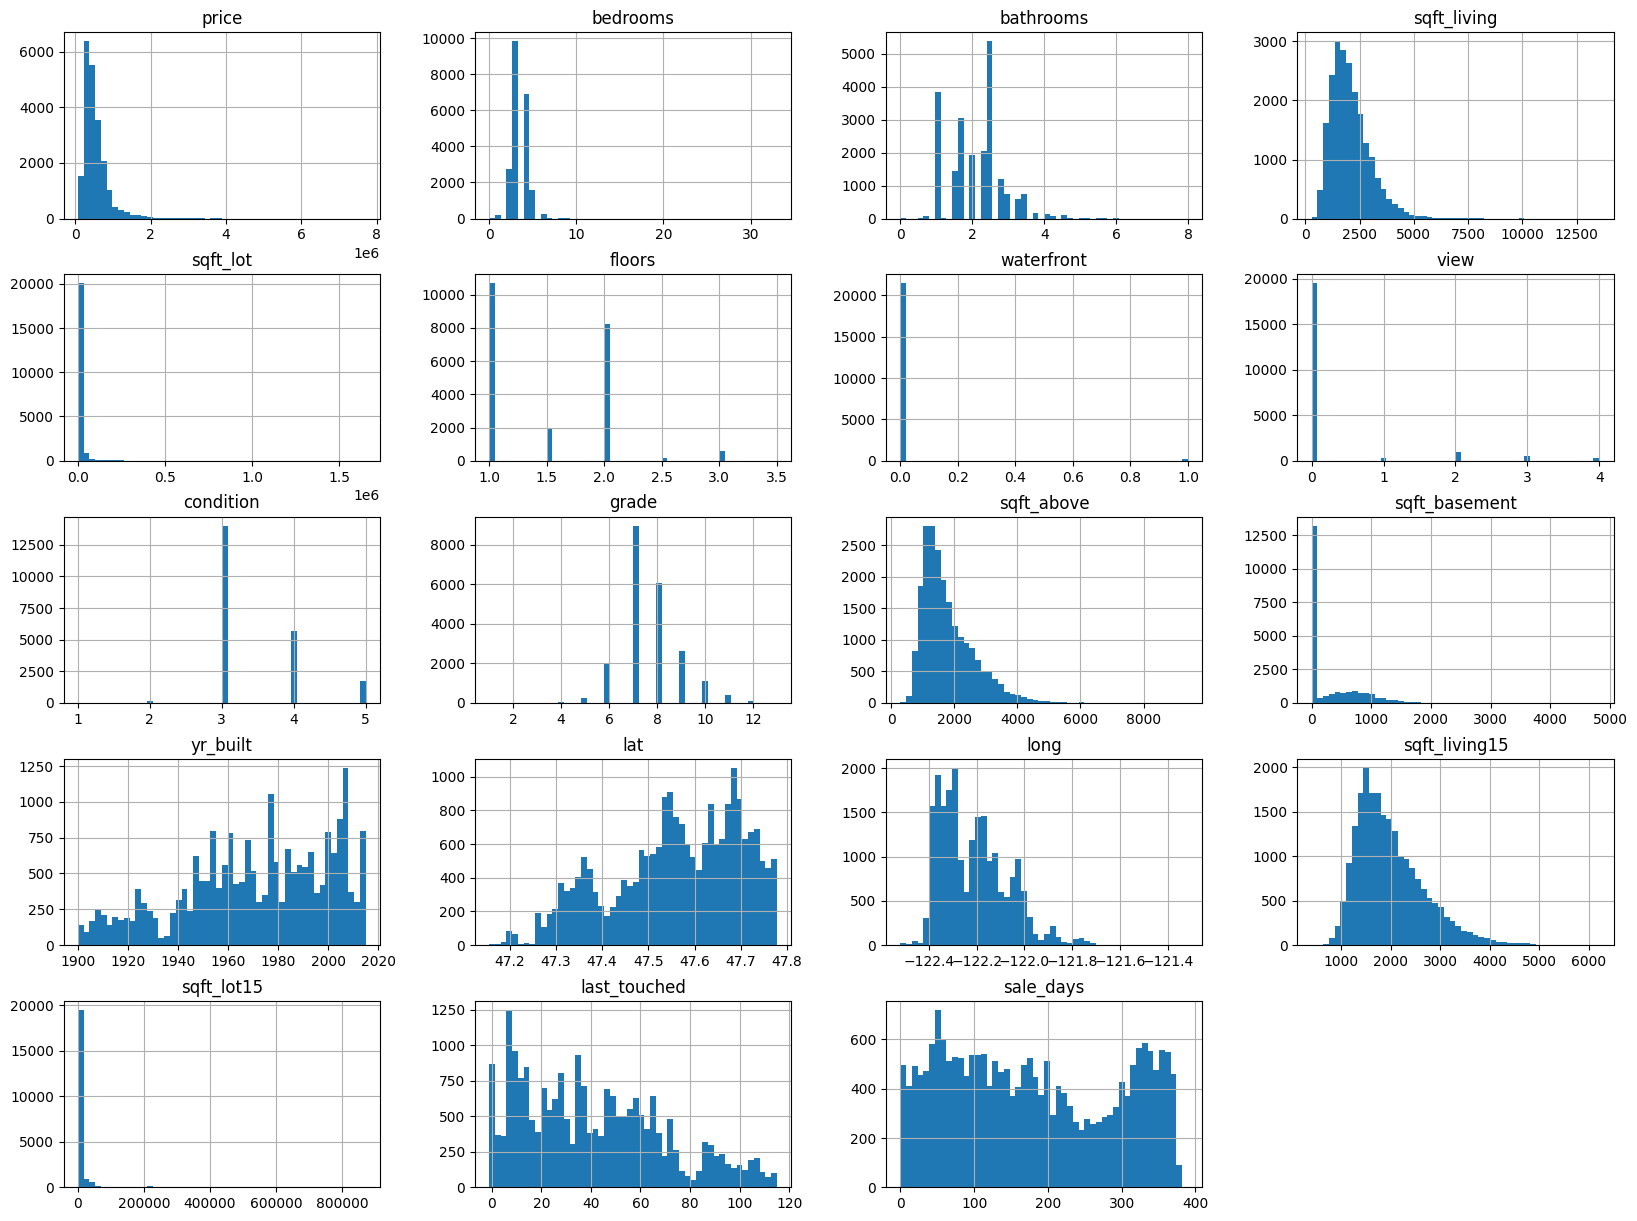

In [7]:
#Automatically creates a histogram for every numeric column
df.hist(bins=50, figsize=(20,15)) #Sets the size of the figure in inches (width=20, height=15)
plt.show() 

#plt.hist(df['sale_days'], bins=50) => Only plots a histogram for one array or one column

### Correlations

Most features seem not to be normally distributed, but for now we will leave them as they are.

What's far more interesting is to see if there are any correlations between the features and the target variable. Correlation is a number that varies between -1 and +1 and tells us how much two different sets of data are similar to each other. The bigger the correlation (either close to 1 or -1) the more the data is correlated with (similar to) each other. If the correlation is 0 then two sets of data are uncorrelated.

An example of a strong **positive correlation** could be the relation between the height and the weight of a person. Generally, if you take measurements of thousands of people you will observe that who taller someone is who heavier. Consequently, it would be possible to predict someone's weight based on their height. 

An example of a strong **negative correlation** could be the relation between the temperature and the amount of clothing people wear. With a sample of thousands of people you will observe that the higher the outside temperature is, the less pieces of clothing they wear. Again, it would be possible to predict the amount of clothing someone is wearing based on the outside temperature.

Finally, no correlation will be found if you tried to relate a person's height and their fluency in English. The correlation coefficient between such series of data would be close to 0.

Let's check the correlation of the target variable *price* with the features:

In [8]:
pd.set_option('display.precision', 3)               #This sets how many decimal places pandas will display when printing numbers. (e.g., 0.456 instead of 0.456789).

# a Series showing how strongly each numeric column is linearly related to price
corr_pear = df.corr(method='pearson')['price']      #uses Pearson correlation => measures linear relationships between variables: 1: perfect positive corr, 0: no linear corr, -1: perfect negative corr

corr_pear = corr_pear.sort_values(ascending=False) #sort highest to lowest
corr_pear

price            1.000
sqft_living      0.702
grade            0.667
sqft_above       0.606
sqft_living15    0.585
bathrooms        0.525
view             0.397
sqft_basement    0.324
bedrooms         0.308
lat              0.307
waterfront       0.266
floors           0.257
sqft_lot         0.090
sqft_lot15       0.082
yr_built         0.054
condition        0.036
long             0.022
sale_days       -0.004
last_touched    -0.106
Name: price, dtype: float64

If you take a look at the output you will see the correlations between the various features and the house prices vary from around -0.1 to 0.7. Usually, correlations above (absolute value of) 0.5 are *very promising* when it comes to building regression models.

Perhaps you have noticed that when calculating the correlations we used the Pearson method. Pearson correlation is used to check if data is *linearly correlated*. That is, given two data series $X$ and $Y$, the relation between them can be described with:

$Y = a*X + b$

Where *a* and *b* are some constants. 

Moreover, Pearson correlation will be higher for normally distributed data. Pandas allows you to calculate correlations using two two other methods: *Kendall* and *Spearman*.

**EXERCISE 2**: Spearman correlation coefficient (2 points)

> Do the written part of this exercise in this Markdown cell.

Find out what the Spearman correlation coefficient is and when it is used. Describe in your own words how it differs from the Pearson correlation coefficient, when it can be used, and when it will give higher values than Pearson correlation. Also give an a real-world example of two features that would (most likely) have a higher Spearman correlation than Pearson correlation.

### Spearman correlation is...

> HERE YOU PUT YOUR ANSWER:   
>#### Spearman Correlation Coefficient
>
>The **Spearman correlation coefficient** measures the **monotonic association** between two variables.
>
>* **Monotonic**: as one variable increases, the other consistently increases or decreases. Don't need to be at a **constant** rate. 
>* **Non-parametric**: does not assume linearity ( The relationship is a straight line ) or normal distribution( The data follows a bell curve ). 
>* Non-parametric methods, like Spearman correlation, don’t assume this: The relationship can be curved or uneven. The data can be skewed, messy, or ranked instead of exact numbers.
>* Calculated using **ranks** (position in the sorted list) of the data. 
>   ```python
>       x = [10, 20, 30, 40]
>       y = [100, 300, 200, 400]
>       Ranks of x: [1, 2, 3, 4]
>       Ranks of y: [1, 3, 2, 4]
>        # Compute correlation using ranks, not the original values.
>       #This measures how well the order of one variable matches the order of the other, ignoring exact differences between values
>   ```
> * Spearman focuses on order or position, not actual distances
> * That’s why it works well for non-linear monotonic relationships
>---
>
>#### Difference from Pearson Correlation
>
>| Feature      | Pearson Correlation                                    | Spearman Correlation                                                                                |
>| ------------ | -------------------------------------------------------| ----------------------------------------------------------------------------------------------------|
>| Measures     | Linear relationship                                    | Monotonic relationship                                                                              |
>| Assumptions  | Linear(need to be constant), normally distributed data | No assumption about linearity or distribution (doesn't need to be constant can be curved or uneven) |
>| Sensitive to | Outliers (can distort results)                         | Less sensitive to outliers                                                                          |
>| Data used    | Actual values                                          | Ranks of values                                                                                     |
>```python
>  #Pearson Correlation
> #(y increases by 2 every time x increases by 1)
>    x = [1,2,3,4]
>    y = [2,4,6,8]
>  #Spearman Correlation  
>    x = [1,2,3,4]
>    y = [2,4,8,16] #(y increases faster each time)
>
>```
>---
>
>##### When to Use Spearman
>
>* Relationship is **non-linear but monotonic**.
>* Data contains **outliers** or is **not normally distributed**.
>* Working with **ordinal/ranked data**.
>
>---
>
>##### When Spearman Can Give Higher Values Than Pearson
>
>* Spearman captures monotonic relationships better than Pearson when they are **non-linear**.
>* Example:
>
>  ```python
>  x = [1, 2, 3, 4, 5]
>  y = [1, 4, 9, 16, 25]
>  # Pearson correlation ≈ 0.97
>  # Spearman correlation = 1 (perfect monotonic increase)
>  ```
>
>---
>
>##### Real-World Example
>
>* **Features:** Years of experience (`x`) and job seniority rank (`y`).
>* **Reason Spearman > Pearson:** Experience generally increases rank, but not linearly. Spearman captures the rank order, Pearson underestimates correlation.
>* **Spearman** looks for **monotonic** relationships => Checks whether the order of y matches the order of x.
> Doesn’t care about the exact amount of change, just that it consistently increases or decreases.
>```python
>       x = [1, 2, 3, 4, 5]
>       y = [1, 4, 9, 16, 25]  # quadratic relationship
>       #Pearson correlation ≈ 0.97 => not perfect, because the increase in y is not constant.
>       # Same example:
>       #Spearman correlation = 1 => perfect correlation because y always increases as x increases, regardless of the curve.
>```

In [9]:
# **EXERCISE 2**: (continued)

# Calculate Spearman correlation for all features with respect to 'price'. 
corr_spear = df.corr(method='spearman')['price']
# Sort and display the results.
corr_spear = corr_spear.sort_values(ascending=False)
#display
corr_spear



price            1.000
grade            0.658
sqft_living      0.644
sqft_living15    0.572
sqft_above       0.542
bathrooms        0.497
lat              0.456
bedrooms         0.345
floors           0.322
view             0.294
sqft_basement    0.252
waterfront       0.115
yr_built         0.102
sqft_lot         0.075
long             0.064
sqft_lot15       0.063
condition        0.018
sale_days       -0.011
last_touched    -0.153
Name: price, dtype: float64

In [10]:
# Do you see any big differences between Spearman and Pearson correlations? If so, for which features?
    #=>explain down
# Combine Pearson and Spearman into one DataFrame for comparison
corr_compare = pd.DataFrame({
    'Pearson': corr_pear,
    'Spearman': corr_spear
}).sort_values(by='Spearman', ascending=False)

corr_compare

,Pearson,Spearman
price,1.000,1.000
grade,0.667,0.658
sqft_living,0.702,0.644
sqft_living15,0.585,0.572
sqft_above,0.606,0.542
bathrooms,0.525,0.497
lat,0.307,0.456
bedrooms,0.308,0.345
floors,0.257,0.322
view,0.397,0.294


>#### Do you see any big differences between Spearman and Pearson correlations? If so, for which features?
>##### Pearson vs Spearman Correlation Comparison
>| Feature          | Pearson | Spearman | Interpretation |
>|------------------|---------|----------|----------------|
>| sqft_living      | 0.70    | 0.64     | Relationship is very linear => Pearson stronger |
>| sqft_living15    | 0.59    | 0.57     | Nearly linear |
>| sqft_above       | 0.61    | 0.54     | Mostly linear |
>| grade            | 0.67    | 0.65     | Very small difference, but still slightly more linear |
>| bathrooms        | 0.53    | 0.49     | Linear-ish |
>| bedrooms         | 0.31    | 0.34     | Slightly more monotonic than linear |
>| floors           | 0.25    | 0.32     | Non-linear but monotonic => Spearman stronger |
>| lat (latitude)   | 0.30    | 0.45     | Strong monotonic relationship; very non-linear |
> * "As the house gets bigger, price increases at a fairly steady rate." => Pearson picks that up better.
> * "As latitude increases, price tends to increase, but not in a straight line." => Spearman's better
> * sqft_lot, sqft_lot15, condition, sale_days, yr_built, last_touched, long (longitude) => Pearson and Spearman both stay close to 0 => both correlations are weak => not good predictors.

While we are talking about correlations, a nice way of looking at them is to plot a so-called *heatmap*. We will use the `seaborn` library for that. `seaborn` is really cool, it's matplotlib on steroids made specifically for the ease of plotting statistical graphics.

> If you don't have seaborn installed (and you should), install it in your virtual environment using pip:
> `pip install seaborn`

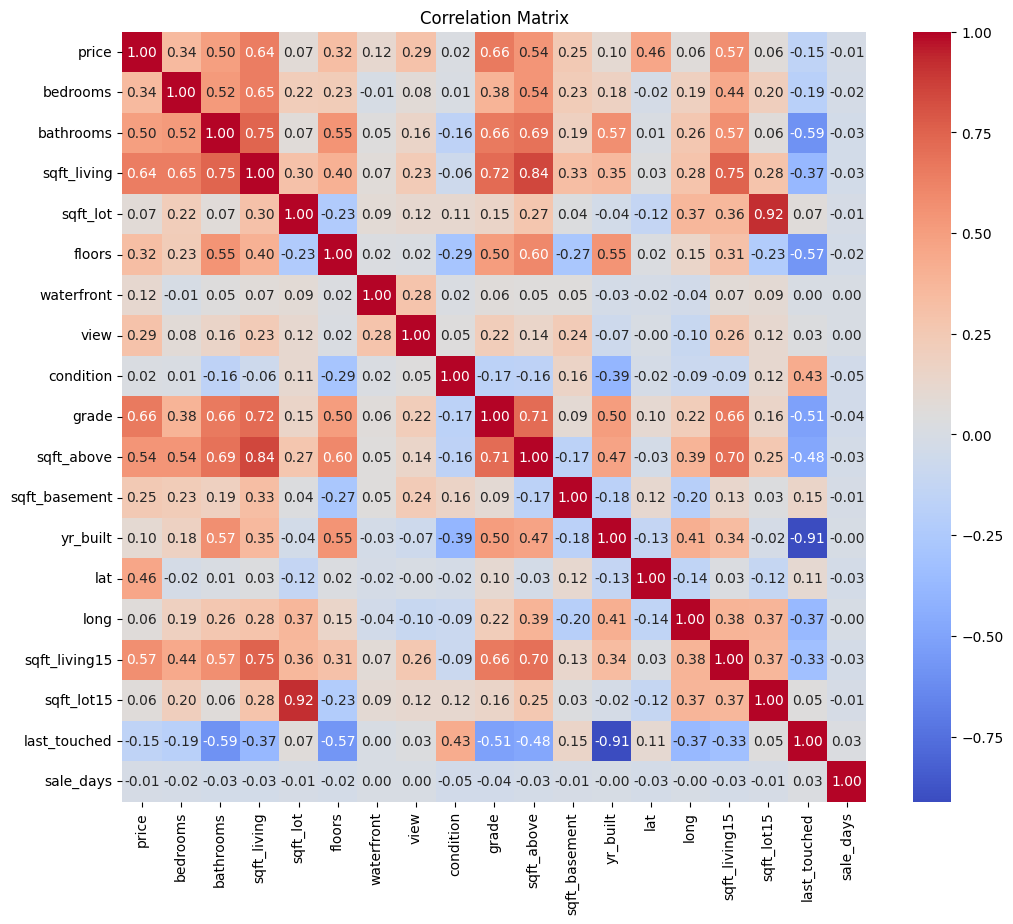

In [11]:
# plot a heatmap of the correlations
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
correlation_matrix = df.corr(method='spearman') #Spearman correlation for every pair of columns in the df

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
#annot=True => write the number on each square
#fmt=".2f" => format numbers with 2 decimal places
#cmap='coolwarm' => blue = low/negative correlation, red = high/positive correlation

plt.title('Correlation Matrix')
plt.show()

One thing you should notice in the heatmap is that `yr_built` and `last_touched` have a very strong negative correlation. Features that have strong correlations (either positive or negative) with each other are said to be [*linearly dependent* or *colinear*](https://en.wikipedia.org/wiki/Multicollinearity). Such features are generally bad (as in *very bad*) for regression models, as they confuse the model. Therefore, we will remove `yr_built` from the set of features.

Moreover, we won't consider features that have very low correlation with the target variable *price*. For this dataset, let's assume that features with absolute **Spearman correlation** below 0.1 (in the range -0.1..0.1) are not useful for predicting the price of a house. 

In [12]:
# **EXERCISE 3** (1 point)

# Create two new variables that we will use for regression:
# target - this should contain only the price column
# features - this should contain all the other columns except:
#    * price and yr_built
#    * features whose Spearman correlation coefficient with price is in the range -0.1 ... 0.1 (spear <= 0.1 and spear >= -0.1)

import pandas as pd

#compute spearman correlations with price
spearman_corr = df.corr(method='spearman')['price']

#select features with |correlation| > 0.1
#exclude 'price' and 'yr_built'
valid_features = spearman_corr[
    (spearman_corr.abs() > 0.1) &   #no need to check -0.1 cuz abs
    (spearman_corr.index != 'yr_built') &  # remove cuz strong neg corr => bad for regression models
    (spearman_corr.index != 'price')].index.tolist() # make a list of those index

#create target and feature
target = df['price']
features = df[valid_features]

print("Selected features: ", valid_features)

Selected features:  ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15', 'last_touched']


### Linear Regression and Learning Curves

Finally, we are ready to do some regression! Or rather you are ready...

In [13]:
# **EXERCISE 4** (1 point)
#
# Build a scikit Pipeline that contains standard scaling (StandardScaler) and linear regression (LinearRegression)
#
# YOU MUST CALL YOUR PIPELINE lin_regressor TO GET POINTS (and to make code below work)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

lin_regressor = Pipeline([
    #Linear regression works better when all features are on similar scales (ex: not mixing dollars, square feet, and latitude).
    ('std_scaler', StandardScaler()),    #Subtracts the mean, divides by the standard deviation => So each feature ends up with: Mean = 0, Standard deviation = 1
    ('lin_reg', LinearRegression())      #LinearRegression model, uses the scaled features
])


Having the pipeline build, now it's time to run linear regression:

1. Split the dataset into the training and validation sets (named: `X_train`, `y_train` for training and `X_test`, `y_test` for validation).
2. Train the model and see what's the RMSE on the training and on the validation data is

In [ ]:
# **EXERCISE 5** (1 point)
#
# 1. Split the dataset into training and testing sets using train_test_split from sklearn.model_selection. Use 20% of the data for testing and set random_state=42.
# 2. Fit the pipeline you created in Exercise 4 on the training data.
# 3. Evaluate the model on the testing data Root Mean Squared Error and print this value.
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(     #80% training data
    features,
    target,
    test_size=0.2, #20% of data for testing
    random_state=42
)

#Fit the pipeline you created in Exercise 4 on the training data.
lin_regressor.fit(X_train, y_train)     #The model looks at X_train and y_train.
                                        #It calculates the weights (coefficients) for each feature and a bias (intercept) so that the line (or hyperplane) fits the data as closely as possible.
                                        #After .fit(), the model "remembers" these coefficients and intercept.
# => teaches the linear regression model how X and y are related so it can make predictions on new data.


#predict on test data
y_pred = lin_regressor.predict(X_test)
    # X_test contains the input features for data the model has never seen before.
    # By predicting y_pred for X_test, we can compare y_pred to the actual y_test to see how well the model generalizes.
    # This gives us an unbiased evaluation of the model.

#compute RMSE => compare predict value with actual value => RMSE measures how far off the model's predictions are from the actual outcomes. 
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
    # y_test => The actual values of the target for the test set.

print("Root Mean Squared Error (RMSE): ", rmse)

#Mean Squared Error (MSE):
    #It measures how far your predictions are from the actual values.
    #Large errors are penalized more (because of the square).
    #Output is in squared units (e.g., dollars(squared), meters(squared)).
#converts MSE into RMSE: by np.sqrt(...)
    # Small RMSE => Model predictions are close to actual values.
    # Large RMSE => Model predictions are far from actual values.
    # RMSE = 0 => perfect predictions
    # If RMSE is, say, 3.5, it means your predictions are off by about 3.5 units on average.


Root Mean Squared Error (RMSE):  219375.0516010081


It also seem like a good time to plot the learning curves for your model. You can do it manually (as shown in slides) or use the `learning_curve` function from `sklearn.model_selection` (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html for help). The learning curves should show both the training and validation RMSE as a function of the number of training samples used. Since the dataset is rather big, you won't be doing it for all possible training set sizes. Instead, you will only do it for 100 different training set sizes, evenly spaced between 1% and 100% of the training data.

If you do the manual method, you can do it like this:

```python
train_sizes = (np.linspace(0.01, 1.0, 100) * len(X_train)).astype('int64')

for train_size in train_sizes:
    # select the first train_size samples from the training data
    X_train_subset = X_train[:train_size]
    y_train_subset = y_train[:train_size]
```

For the `learning_curve` method, pass the named argument `train_sizes=np.linspace(0.01, 1.0, 100)` to the function.


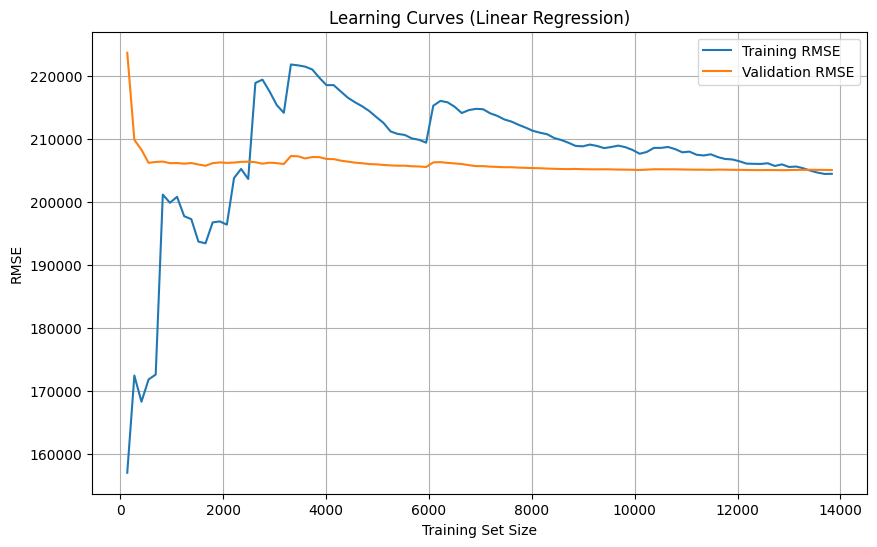

In [ ]:
# **EXERCISE 6** (2 points)
#
# Plot the learning curves for your model.
# Use 100 different training set sizes from 1% to 100% of the training data, as explained above.
# For each training set size, train the model and calculate the RMSE on both the training and validation sets.
# Plot the learning curves (training and validation RMSE vs. training set size) using matplotlib
# IF YOU DO IT MANUALLY, use the train-test split of 0.2
# IF YOU DO IT WITH learning_curve, use cv=5 and average over the folds (splits)

from sklearn.metrics import root_mean_squared_error

# for the learning_curve method (if used)
from sklearn.model_selection import learning_curve

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

lin_regressor = Pipeline([
    ('std_scaler', StandardScaler()),    
    ('lin_reg', LinearRegression())      
])

#100 training sizes from 1% to 100%
train_sizes = np.linspace(0.01, 1.0, 100) 

#use 5-fold CV, compute learning curve
train_sizes_abs, train_scores, val_scores = learning_curve(    #Returns training and validation scores for each size
    estimator=lin_regressor,         # model to evaluate => LinearRegression model
    X=X_train,                       # input features
    y=y_train,                       # target values => #learning_curve() will repeatedly train the model on subsets of this 2 datas. (X_train_subset, y_train_subset)
    train_sizes=train_sizes,         # list of training set size to test 1% -> 100% => model will be trained 100 times, each time with a different amount of data.
    cv=5,                            # Performs cross-validation (cv=5) for each size => Generates 5 training scores, 5 validation scores
    scoring="neg_mean_squared_error" # returns negative MSE by default.
)

# train_sizes_abs: An array with the actual number of samples used for each training size. => Ex: [102, 204, 306, ..., 10240]
# train_scores: A 100 × 5 array: 100 training sizes, 5 CV folds, Each entry = negative MSE on training split => Ex: train_scores.shape == (100, 5) => for each 100 sizes  you have 5 scores
# val_scores: use to compute validation RMSE

#convert negative MSE to RMSE
train_rmse = np.sqrt(-train_scores.mean(axis=1)) #average across columns
val_rmse = np.sqrt(-val_scores.mean(axis=1))

#plot
plt.figure(figsize=(10,6))
plt.plot(train_sizes_abs, train_rmse, label="Training RMSE")
plt.plot(train_sizes_abs, val_rmse, label="Validation RMSE")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curves (Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()

#AS SEEN IN THE GRAPH:
    #High bias (underfitting):
        #Linear Regression is too simple for this dataset.
    #Model improves a bit with more data, but not by much:
        #Both curves flatten out => more data will NOT fix the problem.
    #Training RMSE and validation RMSE converge:
        #This is a classic sign that the model's capacity is too low.

### Residuals

*Residuals* are the differences between the the actual values and the predicted values of the target variable (`y_train - y_train_predict`). In regression analysis, residuals are used to assess the possible problems with a model. They are plotted as a scatter plot with the predicted values on the x-axis and the residuals on the y-axis. A good model will show a random scatter of points around the horizontal line at y=0. If there are patterns in the residuals, it indicates that the model is not capturing some aspect of the data. 

You should probably read this excellent article on residuals: https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/


After quite some reading, let's plot residuals of your linear regression model:

<!-- This doesn't look that impressive - the RMSE is around 5, which given that most values you are trying to predict are in the 20-30 range gives a prediction error of almost 25%! 
We can also plot the errors of our predictions (those are called *residuals*): -->

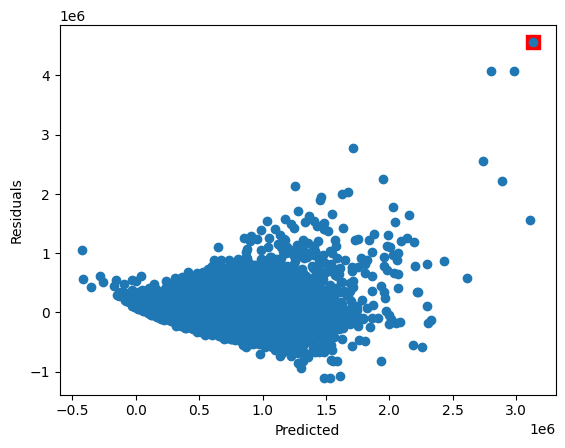

Train RMSE: 204505.4201297225
Test RMSE: 219375.0516010081


In [19]:
# Checking residuals

# split once more for a good measure (not needed if you kept X_test, y_test from before)
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=55)

# tain the model
lin_regressor.fit(X_train, y_train)

# predict on training set
y_train_predict = lin_regressor.predict(X_train)

# select the maximum y_train_predict value and plot its corresponding residual point in red
max_index = np.argmax(y_train_predict)
plt.scatter(y_train_predict[max_index], y_train.iloc[max_index]-y_train_predict[max_index], color='red', s=100, marker='s')

# plot residuals
plt.scatter(y_train_predict, y_train - y_train_predict)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

# RMSE
print("Train RMSE:", root_mean_squared_error(y_train, y_train_predict))
y_test_predict = lin_regressor.predict(X_test)
print("Test RMSE:", root_mean_squared_error(y_test, y_test_predict))

This plot is bad. Despite quite hopeful RMSE of 203000, it looks like for many data points the misprediction is counted in millions. For instance the house that went or 7M is predicted to be worth 3M (red point in the plt). Specifically our model suffers from:

* heteroscedasticity (errors become bigger as the predicted value increases)

* nonlinearity (the errors seem to have some pattern - half of the U letter)
 
Perhaps if we could somehow augment our input data the results could be better. Specifically, we will try normalization and outliers removal to counter heteroscedasticity and feature transformation to counter nonlinearity.

## Data preprocessing and more regression

### Normalization

Heteroscedasticity is often a result of variables with wide ranges of values. Let's look what our data actually looks like - this can be done by plotting histograms (or the density functions) of all the features in the dataset.

We can either use the Pandas dataframe fucntionality or rely on the seaborn library. We will only plot the features that were highly correlated and  that took more than just a few discrete values (like `view` or `condition`).

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15',
       'last_touched'],
      dtype='object')


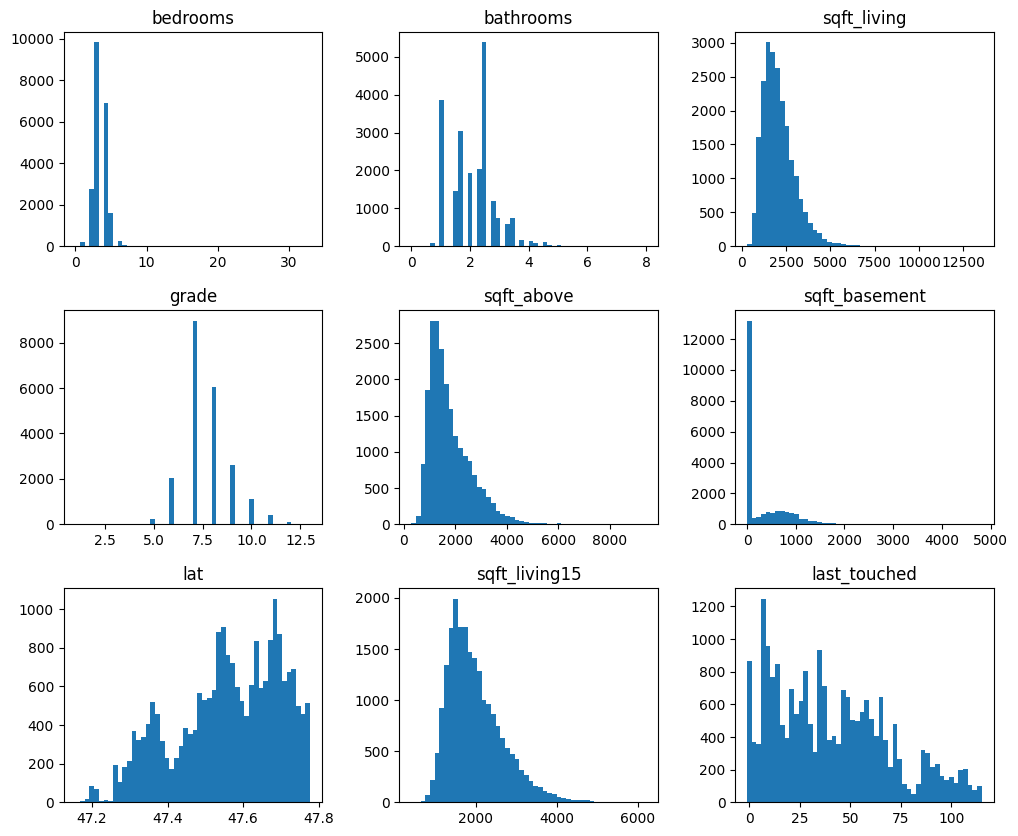

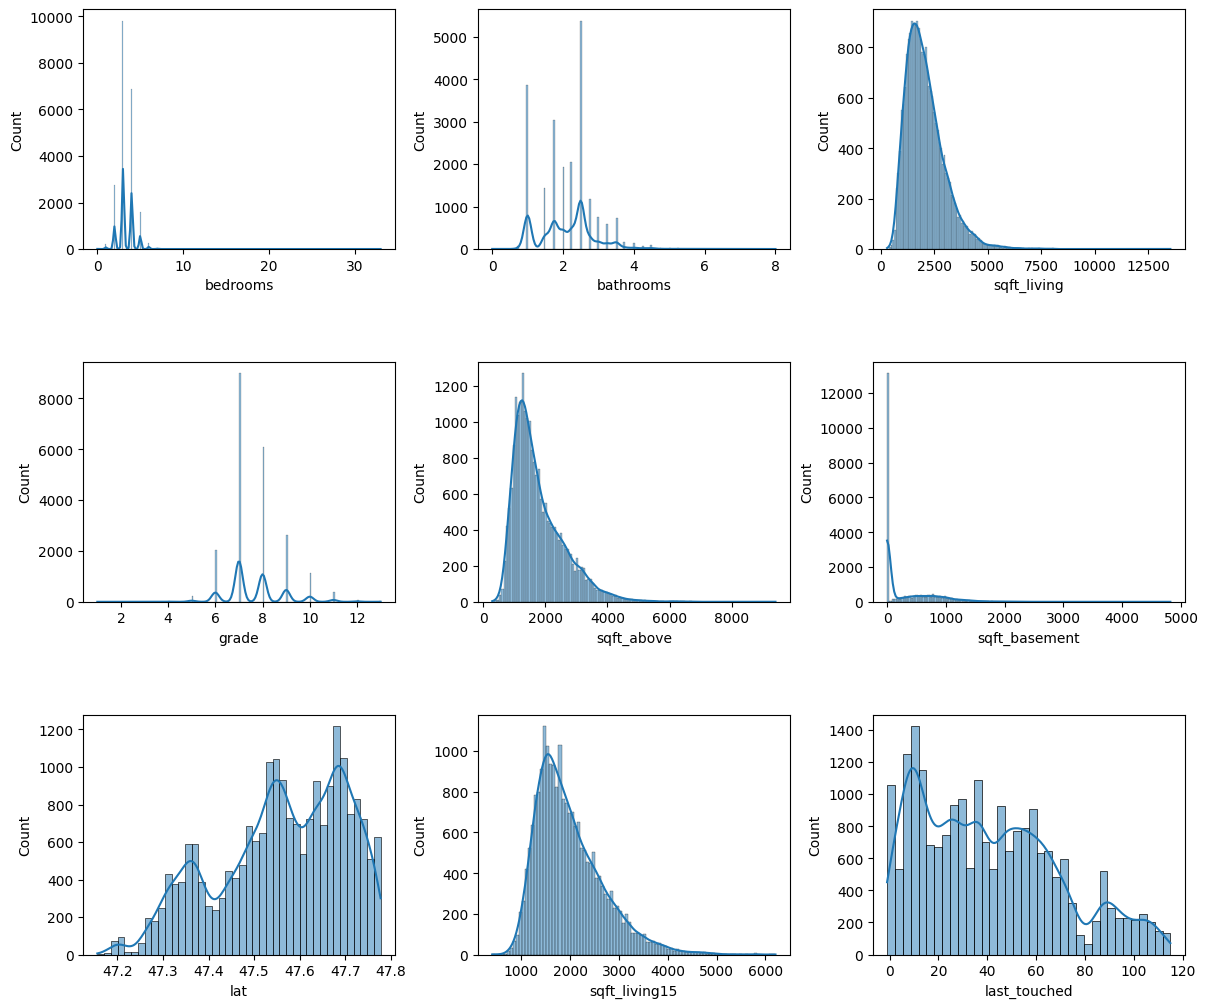

In [20]:
print(features.columns)
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15', 'last_touched']

features[columns].hist(bins=50,figsize=(12,10),grid=False);

# using seaborn
import seaborn as sns

# plot the distributions of all features using seaborn
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 10))
index = 0
axs = axs.flatten()
for k, v in features[columns].items():
    sns.histplot(v, ax=axs[index], kde=True)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

Essentially, those are the same plots, the seaborn-generated ones are a bit nicer but that's the selling point of seaborn.
What you will notice is that some of the features (ok, most) are not normally distributed. Also, many cover a wide range of values (actually all that concern square feet), and this is the main reason why we looked at them. This is not fine for Linear Regression which we are trying to use here. Linear Regression works the best with normally distributed data and data with *homoscedasticity*. Let's fix it somehow. We'll do it by transforming these columns the logarithmic function. Applying a logarithm to has two effects: 

* right-skewed distributions become more normally distributed.
* wide ranges of values are compressed into smaller ranges, reducing heteroscedasticity.

Basic transformation is simple:

```python
log_sqft_living = np.log1p(features['sqft_living'])

```

It applies the function:

$f(x) = \log(x + 1)$

to the feature. The $+1$ is there to avoid problems with $\log(0)$, which is undefined.

Let's see what effect this transformation has on the distribution of the `sqft_living` feature:

In [ ]:
log_sqft_living = np.log1p(features['sqft_living'])


plt.subplots(ncols=2, figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(features['sqft_living'], kde=True)
plt.title('Original sqft_living')
plt.subplot(1, 2, 2)
sns.histplot( log_sqft_living, kde=True)
plt.title('Log-transformed sqft_living')
plt.show()

This is much better than the original! Now we just need to apply this transformation to all the features that need it (those beginning with `sqft_`).
We could create new features in the existing dataframe like this:

```python
features['log_sqft_living'] = np.log1p(df['sqft_living'])
features['log_sqft_above'] = np.log1p(df['sqft_above'])
features['log_sqft_basement'] = np.log1p(df['sqft_basement'])
features['log_sqft_living15'] = np.log1p(df['sqft_living15'])
```

And remove the original features afterwards, but that actively stupid. Our trained model wouldn't be able to process new data without you doing manual transformations first. Instead, we will integrate these transformations into the model pipeline. If you wanted to transform all the features with the same function, you could use the [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) from `sklearn.preprocessing`. To create a function transformer for the logarithm, you can do this:

```python
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, feature_names_out='one-to-one')
```

> The `inverse_func` argument`tells the transformer how to reverse the transformation. The `feature_names_out='one-to-one'` is needed to preserve the original feature names after transformation.

Then to integrate it into the pipeline, you'd write:

```python
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

pipeline = Pipeline([
    ('log_transform', log_transformer),
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])
```

But this won't do since we want to transform only four features, not all of them. To do that, you will use the [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) from `sklearn.compose`. It allows you to apply different transformations to different columns. Here's how you can use it to apply the logarithmic transformation only to the four `sqft_` features:

```python
from sklearn.compose import ColumnTransformer

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, feature_names_out='one-to-one')

column_transformer = ColumnTransformer(
    transformers=[
        ('log_transform', log_transformer, ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15']),
    ],
    remainder='passthrough',  # this means that all other columns are left unchanged
    verbose_feature_names_out = False
)
```

> By default the ColumnTransformer removes (drops) all the columns that are not explicitly transformed. The `remainder='passthrough'` argument tells it to leave all other columns unchanged.
> The `verbose_feature_names_out = False` argument tells the transformer to keep the original feature names for the transformed columns.

In [ ]:
# **EXERCISE 7** (3 points)
#
# Pipeline with feature transformations, and training
#
# 1. Create a pipeline that:
#   * Applies a log transformation to all features whose name starts with 'sqft_' using FunctionTransformer & ColumnTransformer
#   * Standardizes all features using StandardScaler
#   * Uses LinearRegression as the regression model
# YOU MUST CALL YOUR PIPELINE regressor_with_logs TO GET POINTS (and to make code below work)
#
# 2. Fit the pipeline on the training data (use train_test_split with test_size=0.2 and random_state=55)
# 3. Plot the residuals on the training data
# 4. Calculate and print the RMSE on both training and testing data
#


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, feature_names_out='one-to-one')

col_transformer = ColumnTransformer(
    transformers=[
        ('log', log_transformer, [col for col in features.columns if col.startswith('sqft_')]),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# This is not strictly needed, but if you ever want to get a DataFrame output from the ColumnTransformer, you'll need it:
col_transformer.set_output(transform="pandas")

# Your code here


And... dissapointingly, not much has changed. The residuals plot still shows heteroscedasticity and nonlinearity, and the RMSE is still above 200000. Time for some feature transformations!

## Non-linear feature transformations

Let's go full ballistic and try to change the model to a non-linear one by adding polynomial features. Polynomial features are created by taking the original features and raising them to a power (degree). For example, if you have a feature `x`, you can create polynomial features like `x^2`, `x^3`, etc. Moreover, the so-called *interaction features* can be (and will be) also created - these are features that are created by multiplying two different features together (for example, `x1 * x2`). To add polynomial features to your model pipeline, you can use the [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) from `sklearn.preprocessing`. Here's how you can use it:

```python
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
```

Naturally, a polynomial transformer should be a part of the pipeline! As you most likely remember, you should also use regularization when using polynomial features to avoid overfitting. Therefore, instead of `LinearRegression`, you will use `Ridge` regression.

In [ ]:
# **EXERCISE 8** (2 points)
#
# Extend the pipeline from Exercise 7 by adding polynomial features of degree 2
#
# 1. Create a pipeline that:
#   * Applies a log transformation to all features whose name starts with 'sqft_' using FunctionTransformer & ColumnTransformer
#   * Adds polynomial features of degree 2
#   * Standardizes all features using StandardScaler
#   * Uses LinearRegression as the regression model
# 2. Fit the pipeline on the training data (use train_test_split with test_size=0.2 and random_state=55)
# 3. Plot the residuals on the training data
# 4. Calculate and print the RMSE on both training and testing data



from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

Finally, you should see some improvements! The RMSE should drop below  200000, and the residuals plot should look a little bit better.

### Outliers

Now we are going to try to remove outliers - those are the observations that are far away from other observations. The easy way to check for outliers in our feature set is by using boxplots: 

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k, v in features.items():
    sns.boxplot(y=k, data=features, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

As you've learned in week 1, outliers are usually defined as points that are outside 1.5 times the interquartile range (IQR) from the first and third quartiles. They are marked as circles in the boxplots above. It's not always easy to tell which outliers are true outliers (i.e. the data is normally distributed but there are a few off-points that should be removed) or *false outliers* (i.e. either the data is not normally distributed or despite being outside the normal range they are still valid observations). Here, we will focus on the features that start with `sqft_`. (We will only remove the 30-bedroom house because it totally poisons the data). 

To check how many outliers there are for each of the `sqft_` features, you can write:

```python
for col in features.columns:
    if col.startswith('sqft_'):
        Q1 = features[col].quantile(0.25)
        Q3 = features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = features[(features[col] < lower_bound) | (features[col] > upper_bound)]
        print(f"Feature: {col}, Number of outliers: {len(outliers)}")
```

In [ ]:
# Calculate and display the number of outliers in each sqft_ feature using the IQR method
for col in features.columns:
    if col.startswith('sqft_'):
        Q1 = features[col].quantile(0.25)
        Q3 = features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # outliers will only contain the outlier rows for this particular feature (named col here)
        outliers = features[(features[col] < lower_bound) | (features[col] > upper_bound)]
        print(f"Feature: {col}, Number of outliers: {len(outliers)}")

Now it is your time to shine! You will create a copy of the features and target dataframes without the outliers in any of the `sqft_` features. And then use the pipeline with polynomial features and Ridge regression on the cleaned data.

There are many ways to do it. The key is to identify the outliers in each of the `sqft_` features as in the code above, and them remove them. Pandas comes with very powerful filtering methods for this, knowns as [*boolean indexing*](https://pandas.pydata.org/docs/user_guide/indexing.html#boolean-indexing). When you write:

```python
df_filtered = df[condition]
```

where `condition` is a boolean series (a series of `True` and `False` values) of the same length as the dataframe `df`, you get a new dataframe `df_filtered` that contains only the rows where the corresponding value in `condition` is `True`. The condition can be produced using comparisons and logical operations on the dataframe columns. For instance, the following creates two different masks (conditions) and uses them to filter the dataframe:

```python
# create a mask for items where sqft_living is less than 5000
mask1 = features['sqft_living'] < 5000
# and another mask for items where sqft_lot is greater than 100000 and bedrooms are at least 3
mask2 = (features['sqft_lot'] > 100000) & (features['bedrooms'] >= 3)

features_filtered1 = features[mask1]
features_filtered2 = features[mask2]
```

Most often then not, such masks are repeatidly applied, often in a loop, to filter out multiple conditions. With the two masks above, we could filter the dataframe to only include rows that satisfy both conditions like this:

```python
combined_mask = mask1 & mask2
features_filtered = features[combined_mask]
```

Or using the loop approach (which is more relevant to our outlier removal task):

```python
# first create a copy of the features dataframe, we don't want to modify the original!
features_filtered = features.copy()

# now apply the masks one by one, reassigning the filtered dataframe each time
for mask in [mask1, mask2]:
    features_filtered = features_filtered[mask]
```

In [ ]:
# **EXERCISE 9** (2 points)
#
# In this exercise you will work with copies of the features and target dataframes where outliers have been removed.
# These copies are already created for you below as features_no and target_no.
#
# 1. Remove outliers from all sqft_ features using the IQR method - you already have most of the code for this in the previous Python cell
# 2. You may (or you may not, it's up to you) also remove the 30-bedroom house from the dataset if it's still there after doing the previous step.
# 2. Repeat the training of the pipeline from Exercise 8 on the new data without outliers
# 3. Plot the residuals on the training data
# 4. Calculate and print the RMSE on both training and testing data


# Remove outliers from sqft_ features using the IQR method
# important: do not modify original dataframes, instead create new frames features_no, target_no
features_no = features.copy()
target_no = target.copy()